# Brain Tumor Detection Using Computer Vision.

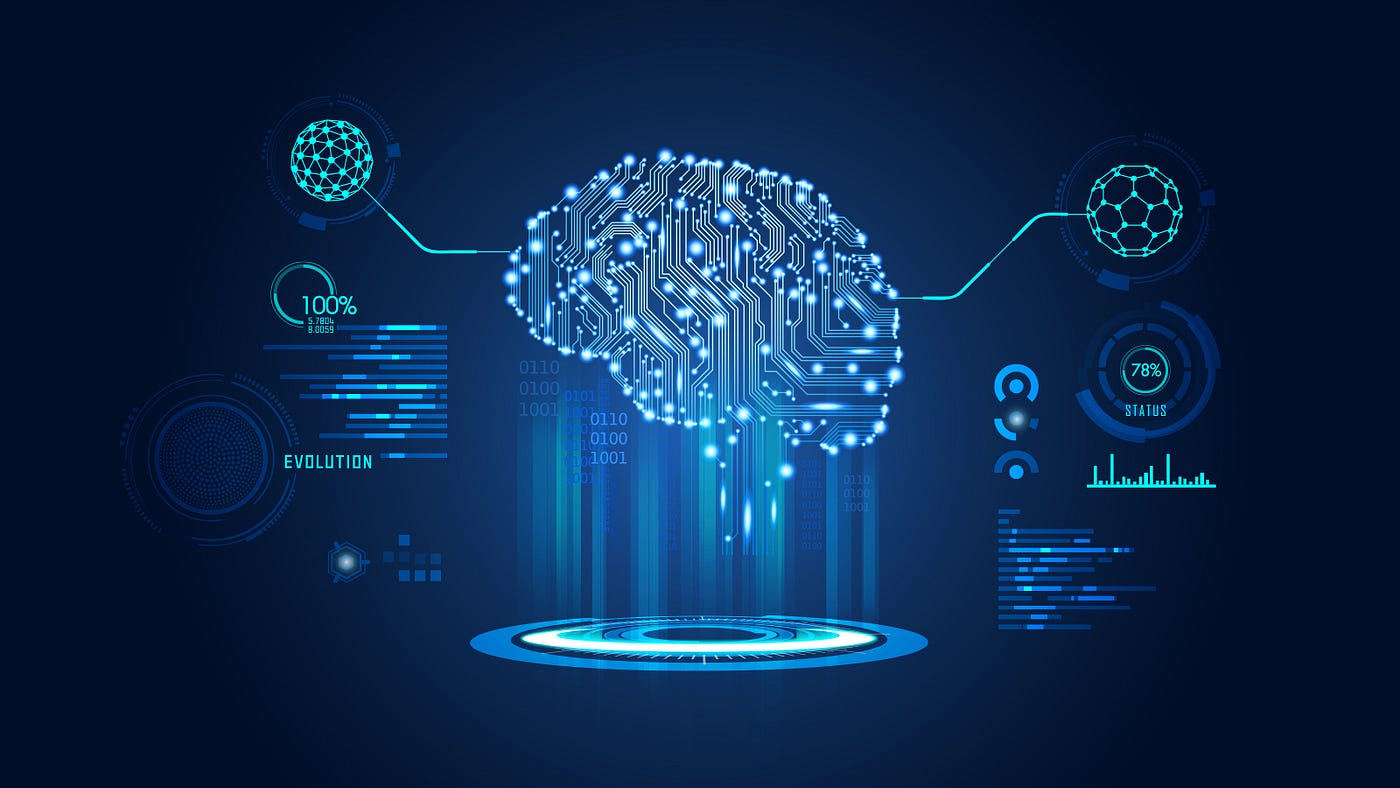


1) Overview : Explored different Computer Vision Models on the Brain MRI Dataset.

2) Objective : Build a system for Automatic Detection of Tumor in Brain MRI samples.

3) Model Choice : Utilize CNN (Convolutional Neural Networks) , DenseNet , VGG16.

4) Implementation : Implemented with TensorFlow , OpenCV , Seaborn , Keras , Scikit-Learn.

# Importing The Necessary Modules and Libraries.

In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
import glob
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input,Conv2D, Dense, Flatten ,Dropout ,MaxPooling2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler,ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,RMSprop
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import regularizers

In [2]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Importing The Dataset and Combining It Using OpenCV.

It is the "Brain MRI Images for Brain Tumor Detection" Dataset from Kaggle so it is already clean. 
The only problem was that it did not had any labels assigned to it. 
So, we used glob , OpenCV to load the image one by one and add the label. Then we append the image/label tuple to a List and combine the list to create a single list.

In [3]:
path_yes=r'C:\Users\Nihar\Desktop\Tumor Detection CV\yes\*'
path_no=r'C:\Users\Nihar\Desktop\Tumor Detection CV\no\*'
tumor = []
no_tumor = []
random_state = 42

for file in glob.iglob(path_yes):
    img=cv2.imread(file)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(128,128))
    tumor.append((img,1))
    
for file in glob.iglob(path_no):
    img=cv2.imread(file)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(128,128))
    no_tumor.append((img,0))
    
all_data= (tumor + no_tumor)

data=np.array([item[0] for item in all_data])

labels=np.array([item[1] for item in all_data])

Display of a few examples from the Dataset.

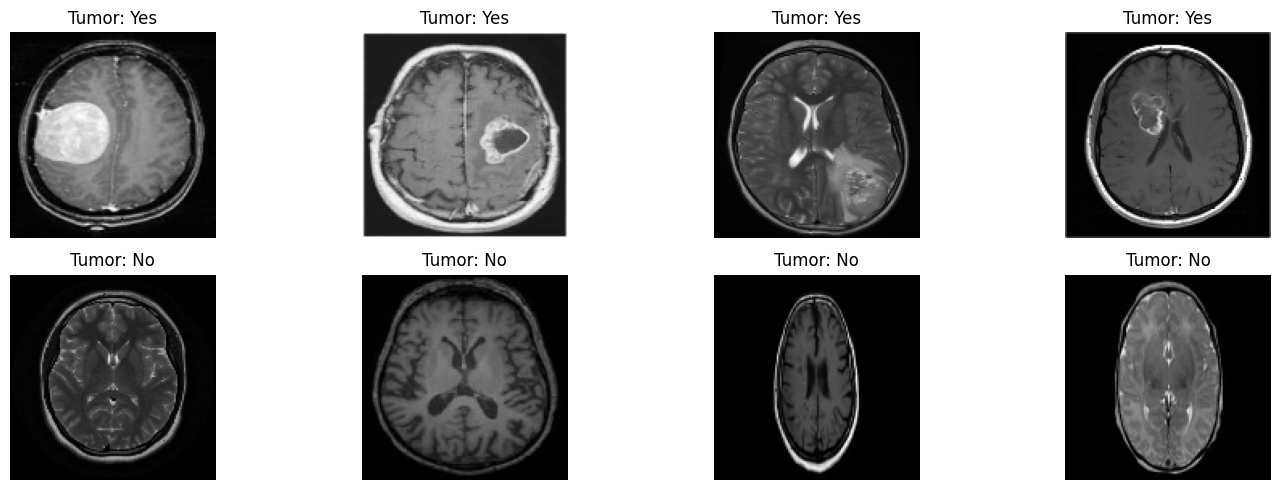

In [4]:
plt.figure(figsize=(15,5))

for i in range(4):
    plt.subplot(2,4,i+1)
    plt.imshow(tumor[i][0])
    plt.title("Tumor: Yes")
    plt.axis('off')
    

for i in range(4):
    plt.subplot(2,4,i+5)
    plt.imshow(no_tumor[i][0])
    plt.title("Tumor: No")
    plt.axis('off')
    
plt.tight_layout()
plt.show()

Label Distribution.

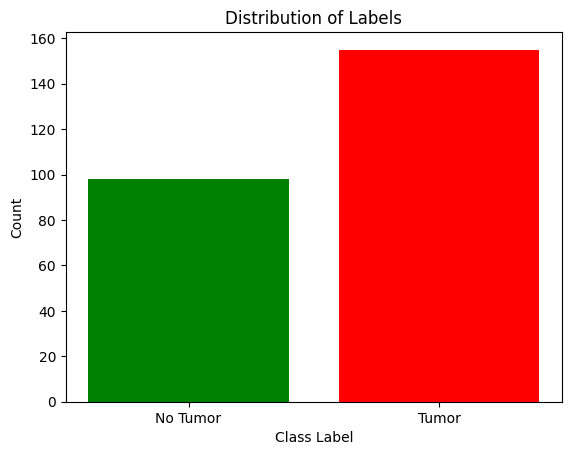

In [5]:
unique_labels , label_counts=np.unique(labels,return_counts=True)
plt.bar(unique_labels,label_counts,color=['Green','Red'])
plt.xticks(unique_labels , ['No Tumor' , 'Tumor'])
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.show()

# Cropping The Images

The function crop_brain_region finds the contours in the image and then creates the bounding box of the brain. This helps us crop the image which focuses on the important part of the image and removes the irrelevant part.

In [6]:
def crop_brain_region(image, size):
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Applying Gaussian blur to smooth the image and reduce noise
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Thresholding the image to create a binary mask
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    
    # Performing morphological operations to remove noise
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    
    # Finding contours in the binary mask
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Assuming the brain part of the image has the largest contour
    c = max(contours, key=cv2.contourArea)
    
    x, y, w, h = cv2.boundingRect(c)
    
    # Drawing contours on the original image
    contour_image = cv2.drawContours(image.copy(), [c], -1, (0, 255, 0), 2)
    
    # Drawing bounding box on the original image
    bounding_box_image = cv2.rectangle(image.copy(), (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    # Cropping the image around the bounding rectangle
    cropped_image = image[y:y+h, x:x+w]
    
    resized_image = cv2.resize(cropped_image, size)
    
    return contour_image, bounding_box_image, cropped_image, resized_image
    

Demonstration of the above function is shown.

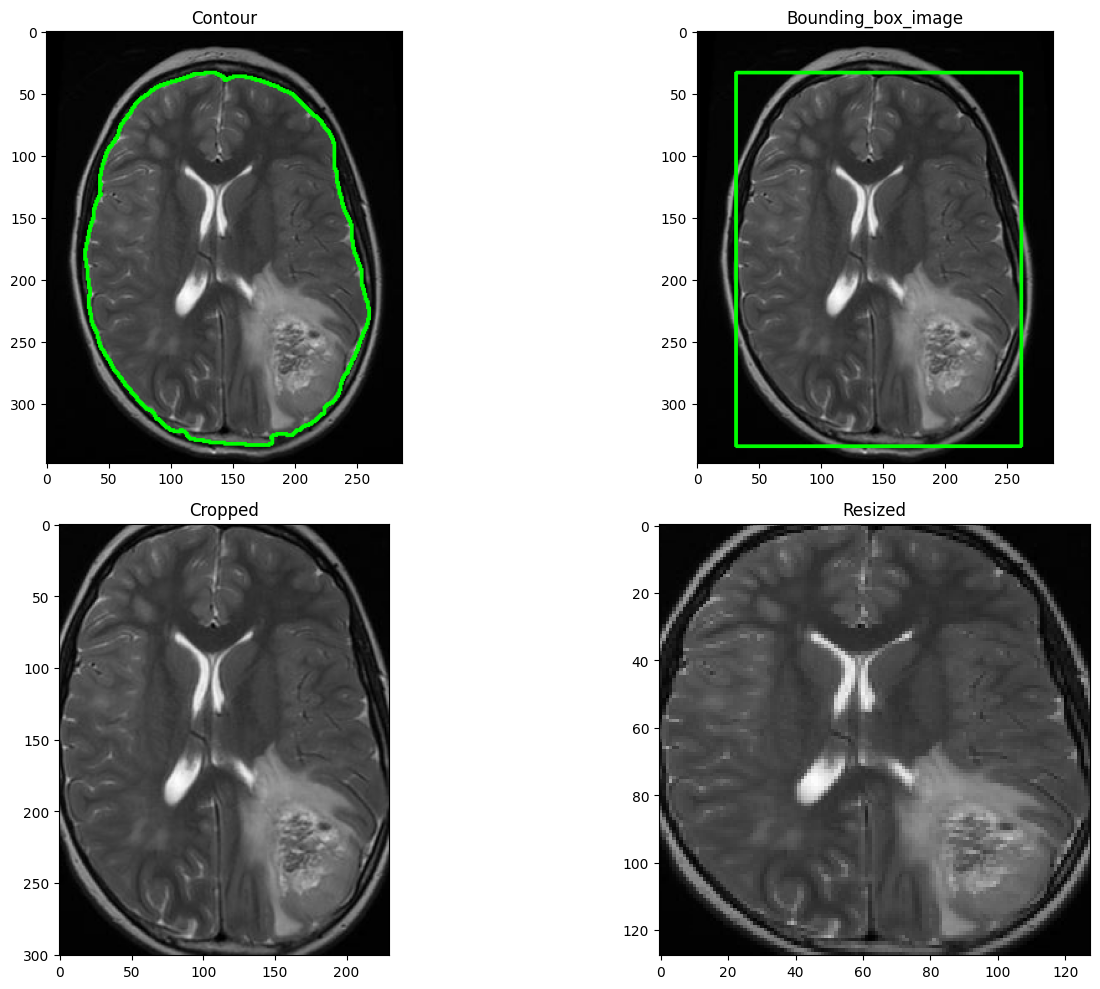

In [7]:
output_size=(128,128)

example_image=cv2.imread(r'C:\Users\Nihar\Desktop\Tumor Detection CV\yes\Y100.JPG')

example_image=cv2.cvtColor(example_image , cv2.COLOR_BGR2RGB)

contour_image,bounding_box_image,cropped_image,resized_image=crop_brain_region(example_image,output_size)

plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.imshow(contour_image)
plt.title("Contour")

plt.subplot(2,2,2)
plt.imshow(bounding_box_image)
plt.title("Bounding_box_image")

plt.subplot(2, 2, 3)
plt.imshow(cropped_image)
plt.title("Cropped")

plt.subplot(2, 2, 4)
plt.imshow(resized_image)
plt.title("Resized")

plt.tight_layout()
plt.show()

all_cropped = []

# Applying the crop function to each one of our images
for image in data:
    _, _, _, resized_image = crop_brain_region(image, output_size)
    all_cropped.append(resized_image)

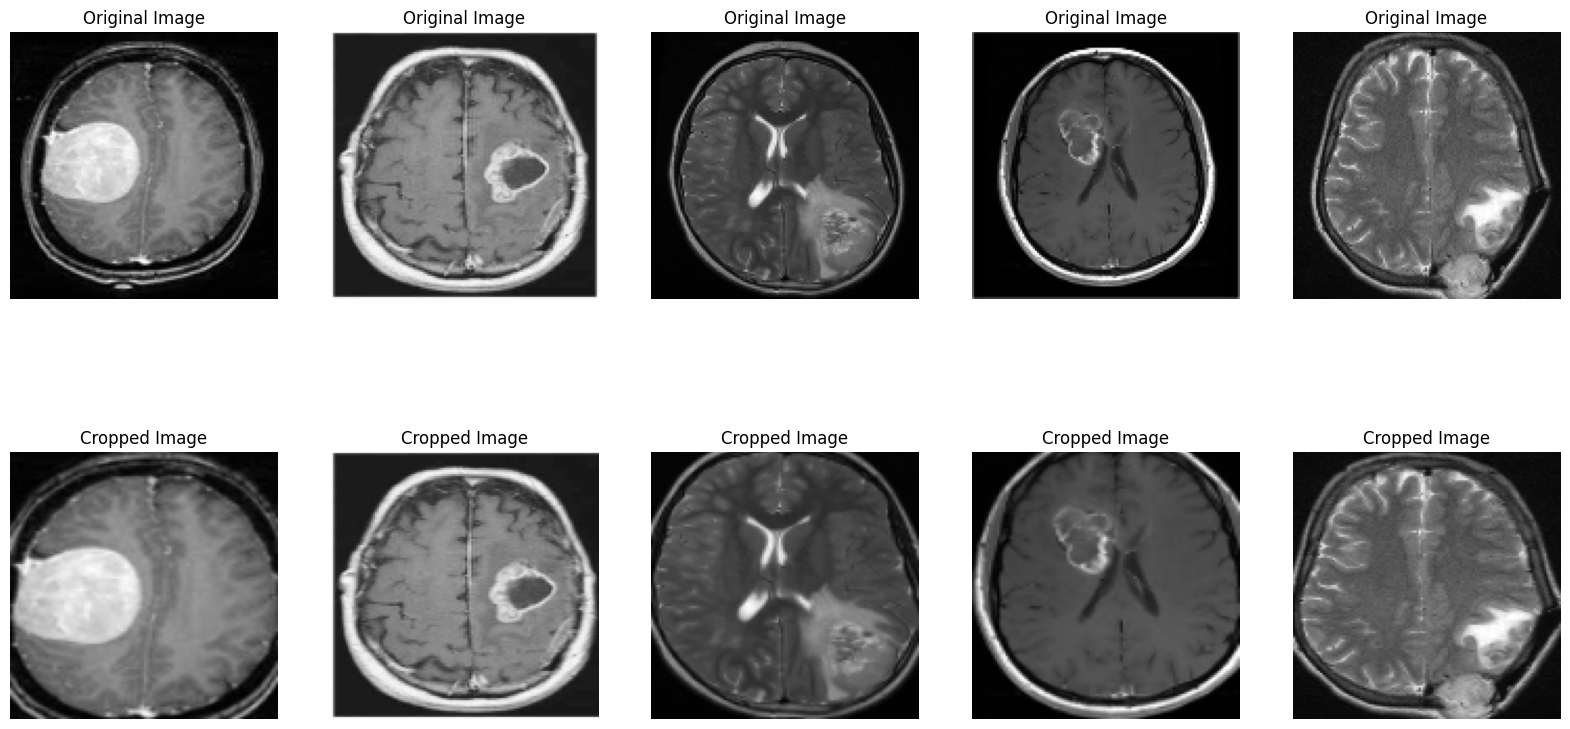

In [8]:
num_images_per_class = 5

class_0_counter = 0
class_1_counter = 0

plt.figure(figsize=(20, 10))

for i in range(num_images_per_class):
    plt.subplot(2, num_images_per_class, i + 1)
    plt.imshow(data[i])
    plt.title("Original Image")
    plt.axis("off")

for i in range(num_images_per_class):
    plt.subplot(2, num_images_per_class, num_images_per_class + i + 1)
    plt.imshow(all_cropped[i])
    plt.title("Cropped Image")
    plt.axis("off")

plt.show()

In [9]:
all_cropped=np.array(all_cropped)

In [10]:
all_cropped_shuffled, labels_shuffled = shuffle(all_cropped, labels, random_state=42)
#shuffling of data

train_images, test_images, train_labels, test_labels = train_test_split(all_cropped_shuffled, labels_shuffled, test_size=0.2, random_state=42)
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=42)

print("Train data shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Validation data shape:", val_images.shape)
print("Validation labels shape:", val_labels.shape)
print("Test data shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Train data shape: (202, 128, 128, 3)
Train labels shape: (202,)
Validation data shape: (26, 128, 128, 3)
Validation labels shape: (26,)
Test data shape: (25, 128, 128, 3)
Test labels shape: (25,)


In [11]:
print(np.max(train_images))
print(np.min(train_images))

255
0


Normalizing the pixel values.

In [12]:
train_images=train_images/255
test_images=test_images/255
val_images=val_images/255

print(np.max(train_images))
print(np.min(train_images))

1.0
0.0


# Creating a Convolutional Neural Network

In [13]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=1e-4))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

# Training of The Model.

The model is stopped early to prevent overfitting with the help of callbacks.

In [14]:
epochs = 50 
batch_size = 32 

early_stopping = EarlyStopping(patience=5, monitor='val_loss')  # Defining early stopping to stop the model from overfitting


history = model.fit(train_images, 
                    train_labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(val_images, val_labels),
                   callbacks=[early_stopping])

Epoch 1/50
7/7 [==============================] - 5s 537ms/step - loss: 0.6812 - accuracy: 0.5693 - val_loss: 0.6357 - val_accuracy: 0.6923
Epoch 2/50
7/7 [==============================] - 3s 472ms/step - loss: 0.6567 - accuracy: 0.6089 - val_loss: 0.6181 - val_accuracy: 0.6923
Epoch 3/50
7/7 [==============================] - 4s 532ms/step - loss: 0.6619 - accuracy: 0.6089 - val_loss: 0.6155 - val_accuracy: 0.6923
Epoch 4/50
7/7 [==============================] - 3s 487ms/step - loss: 0.6446 - accuracy: 0.6089 - val_loss: 0.6223 - val_accuracy: 0.6923
Epoch 5/50
7/7 [==============================] - 3s 480ms/step - loss: 0.6598 - accuracy: 0.6089 - val_loss: 0.6256 - val_accuracy: 0.6923
Epoch 6/50
7/7 [==============================] - 3s 493ms/step - loss: 0.6432 - accuracy: 0.6089 - val_loss: 0.6116 - val_accuracy: 0.6923
Epoch 7/50
7/7 [==============================] - 3s 471ms/step - loss: 0.6310 - accuracy: 0.6089 - val_loss: 0.5981 - val_accuracy: 0.6923
Epoch 8/50
7/7 [====

Model Architecture of The above CNN.

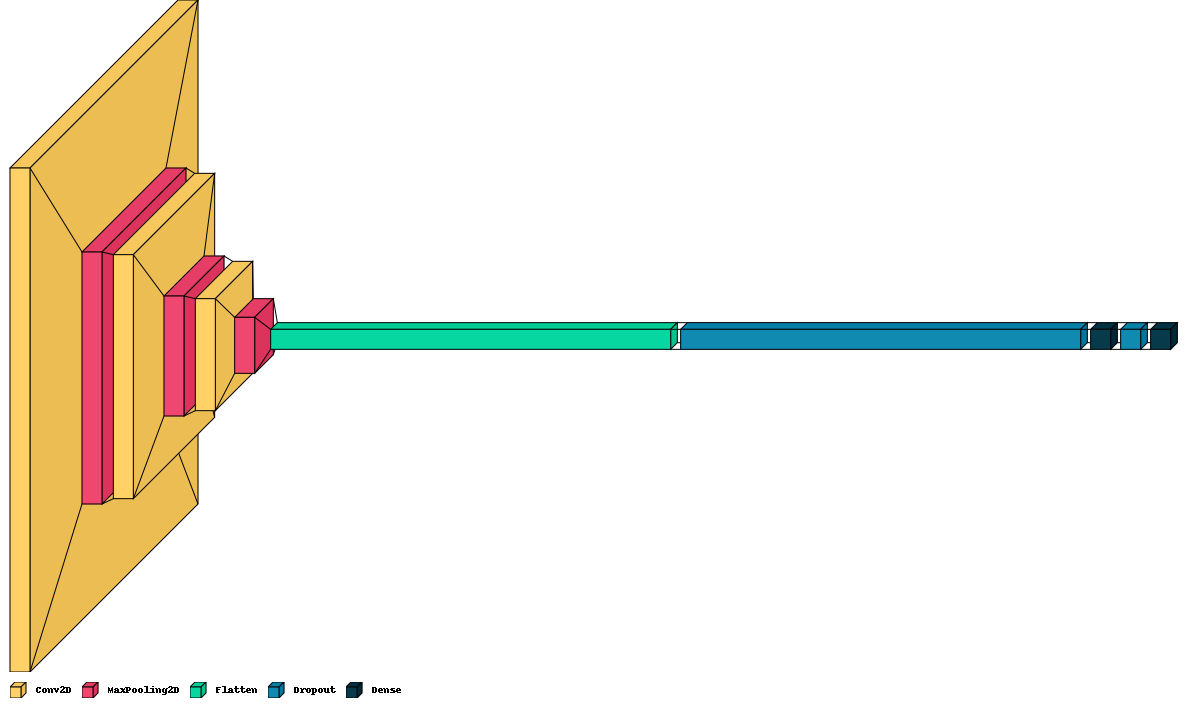

In [15]:
import visualkeras
visualkeras.layered_view(model , legend=True)

Validation Confusion Matrix and some Results

1/1 [==============================] - 0s 289ms/step
Accuracy on Validation Set: 0.808 %


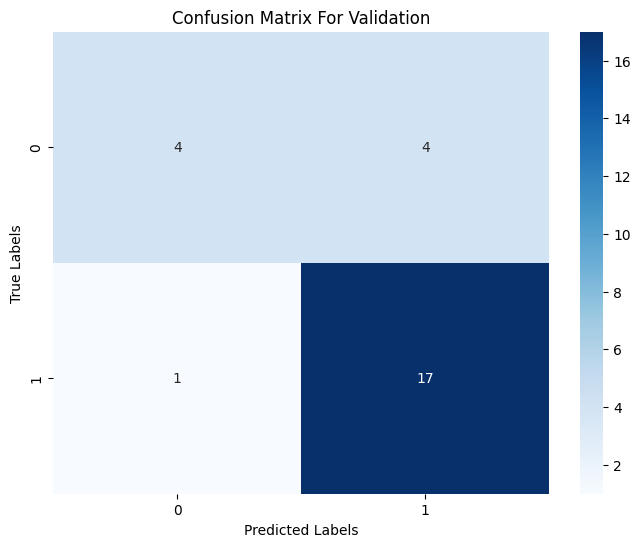

In [16]:
predictions = model.predict(val_images)
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

conf_matrix = confusion_matrix(val_labels, binary_predictions)

accuracy = accuracy_score(val_labels, binary_predictions)
print("Accuracy on Validation Set: {:.3f} %".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Validation')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

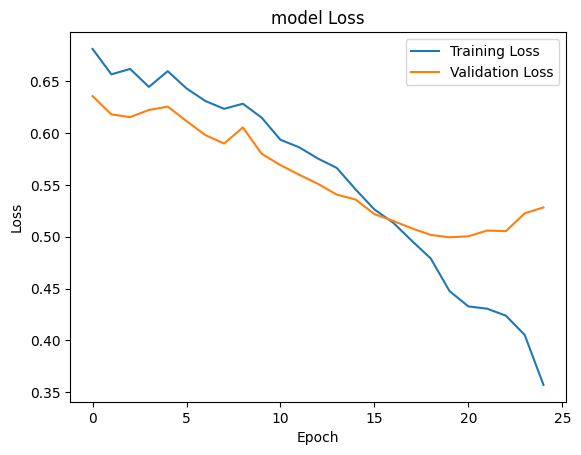

In [17]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Test Confusion Matrix and some Results.

1/1 [==============================] - 0s 141ms/step
Accuracy on Test Set: 0.880 %


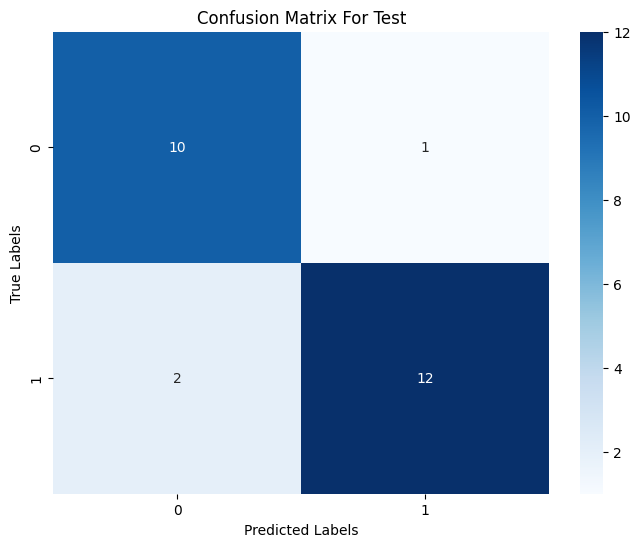

In [18]:
predictions = model.predict(test_images)
threshold = 0.5 
binary_predictions = (predictions > threshold).astype(int)

conf_matrix = confusion_matrix(test_labels, binary_predictions)

accuracy = accuracy_score(test_labels, binary_predictions)
print("Accuracy on Test Set: {:.3f} %".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Test')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

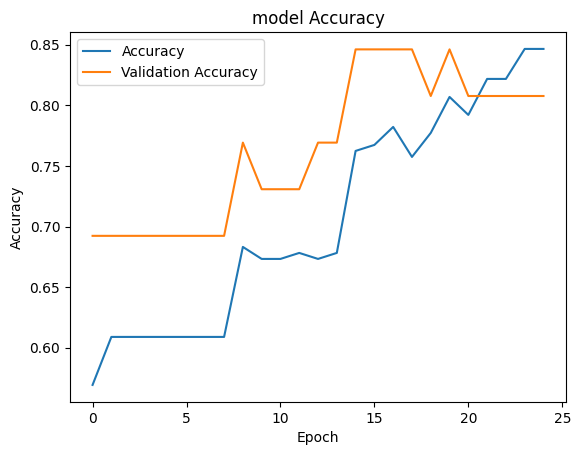

In [19]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Data Augmentation.

This process is done to create new data from the existing data by changing some properties of the given data. Here we use different techniques of changing the images by zooming , intensity , flipping , rotation and many more.

In [20]:
train_datagen = ImageDataGenerator(
    rotation_range=20,         #rotation     
    horizontal_flip=True,      #flipping   
    vertical_flip=True,             
    width_shift_range=0.1,     #shifting   
    height_shift_range=0.1,         
    shear_range=0.1,                
    zoom_range=0.1,            #zooming
)

val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(
    train_images, train_labels,
    batch_size=32
)

val_generator = val_datagen.flow(
    val_images, val_labels,
    batch_size=32
)

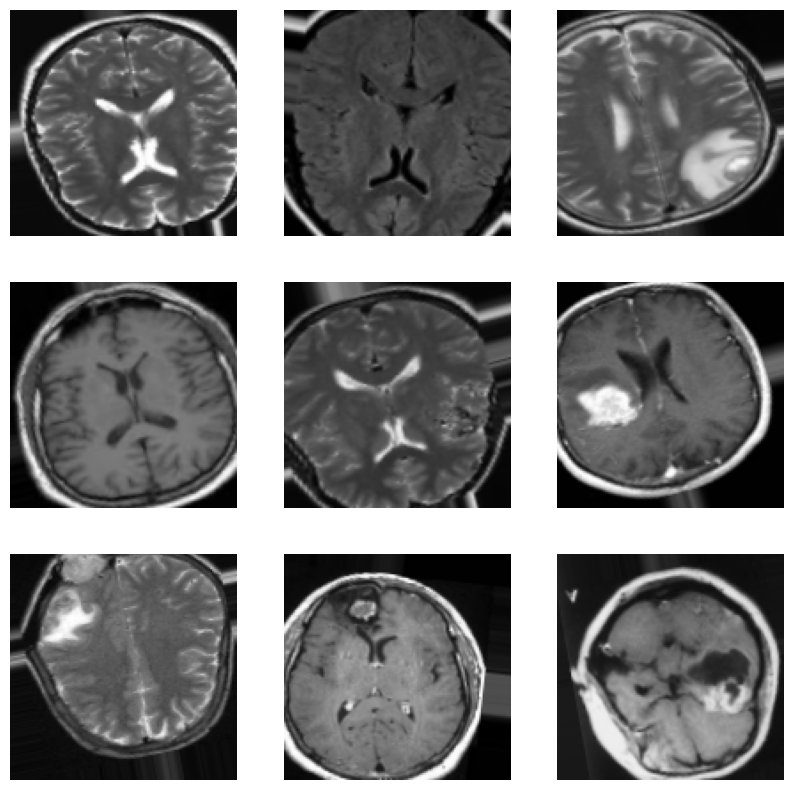

In [21]:
augmented_images = train_datagen.flow(train_images, train_labels, batch_size=32)

# Get the next batch of augmented images
augmented_images_batch, _ = next(augmented_images)

# Display augmented images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images_batch[i])
    plt.axis('off')
plt.show()

# Using and Modifying DenseNet x2 Model.

In [22]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
import numpy as np

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
#freeze the layers
for layer in base_model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)  
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

Model Architecture

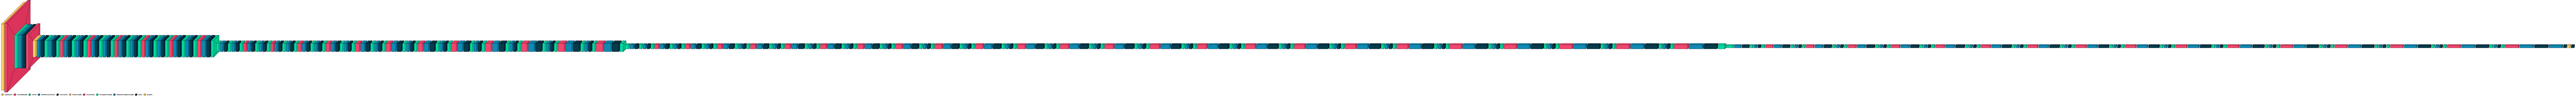

In [23]:
visualkeras.layered_view(model , legend=True)

Using Variation in Epochs 

Training model with 50 epochs...
1/1 [==============================] - 5s 5s/step
Epochs: 50
Accuracy: 0.84
Precision: 0.8125
Recall: 0.9285714285714286
F1 Score: 0.8666666666666666


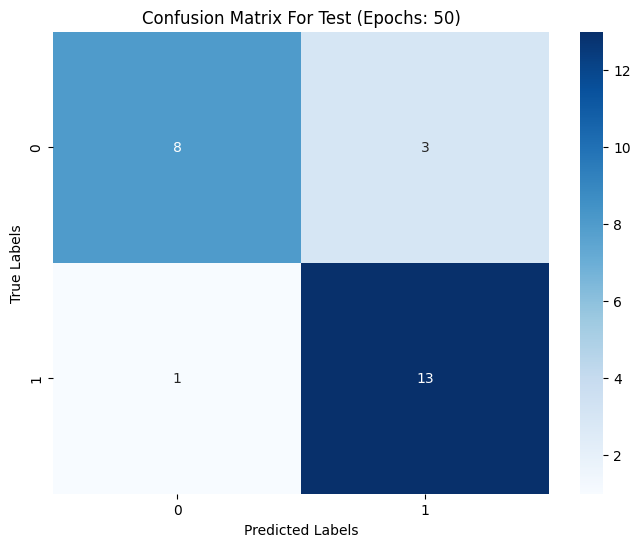

Training model with 100 epochs...
1/1 [==============================] - 1s 1s/step
Epochs: 100
Accuracy: 0.84
Precision: 0.8125
Recall: 0.9285714285714286
F1 Score: 0.8666666666666666


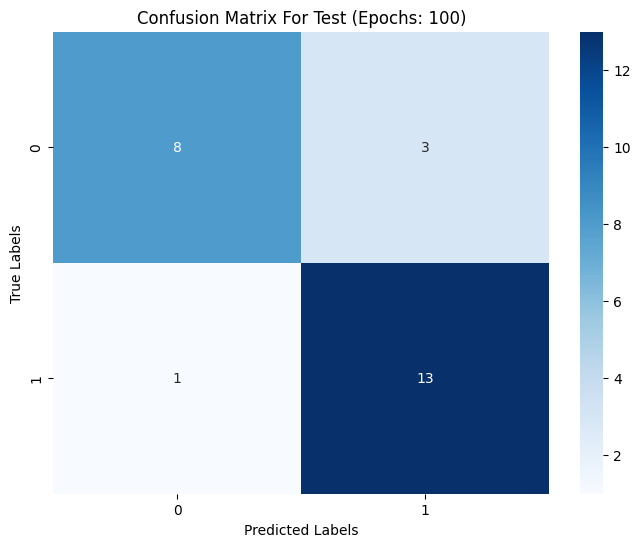

Training model with 150 epochs...
1/1 [==============================] - 1s 871ms/step
Epochs: 150
Accuracy: 0.88
Precision: 0.8666666666666667
Recall: 0.9285714285714286
F1 Score: 0.896551724137931


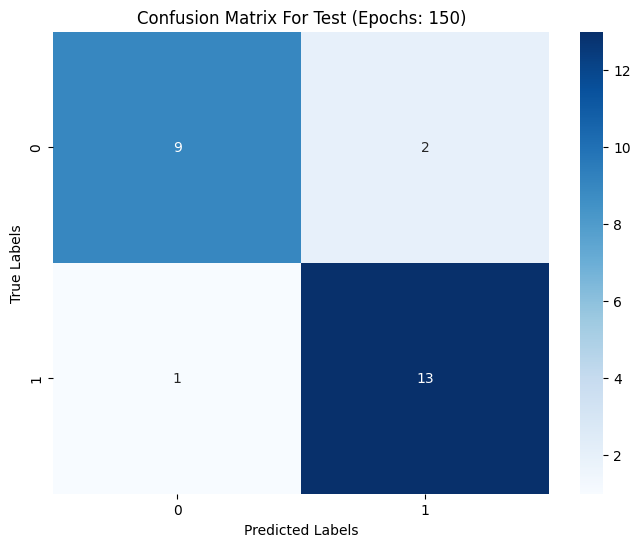

Training model with 200 epochs...
1/1 [==============================] - 1s 826ms/step
Epochs: 200
Accuracy: 0.84
Precision: 0.8125
Recall: 0.9285714285714286
F1 Score: 0.8666666666666666


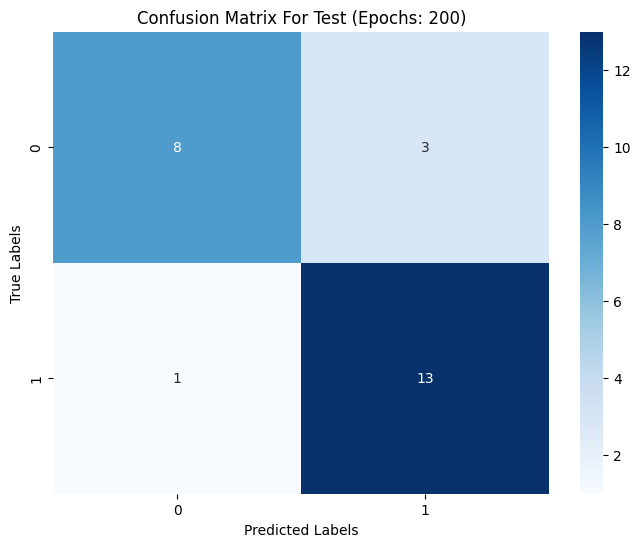

Training model with 250 epochs...
1/1 [==============================] - 1s 840ms/step
Epochs: 250
Accuracy: 0.88
Precision: 0.8666666666666667
Recall: 0.9285714285714286
F1 Score: 0.896551724137931


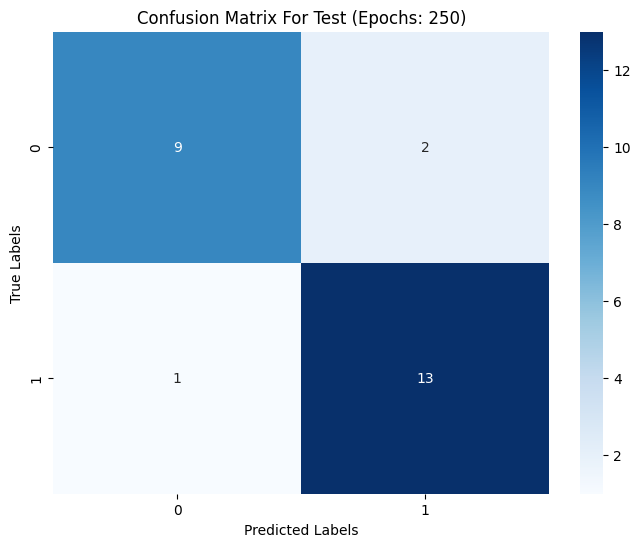

Training model with 300 epochs...
1/1 [==============================] - 1s 922ms/step
Epochs: 300
Accuracy: 0.84
Precision: 0.8125
Recall: 0.9285714285714286
F1 Score: 0.8666666666666666


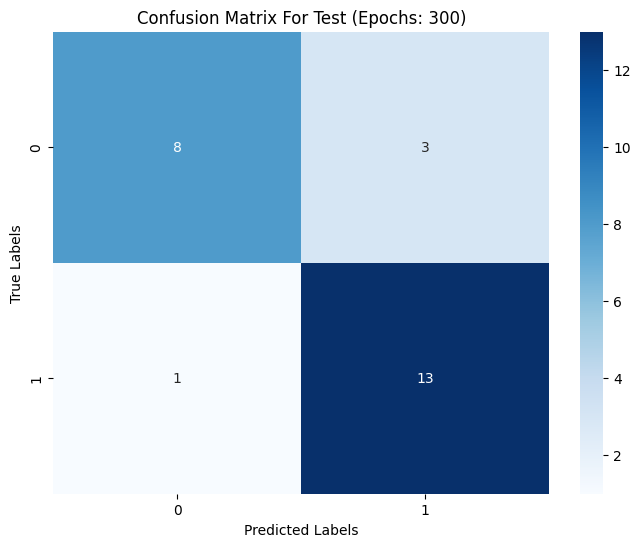

   Epochs  Accuracy  Precision    Recall  F1 Score
0      50      0.84   0.812500  0.928571  0.866667
1     100      0.84   0.812500  0.928571  0.866667
2     150      0.88   0.866667  0.928571  0.896552
3     200      0.84   0.812500  0.928571  0.866667
4     250      0.88   0.866667  0.928571  0.896552
5     300      0.84   0.812500  0.928571  0.866667


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# List of epochs to experiment with
epochs_to_try = [50, 100, 150, 200, 250, 300]

# Dictionary to store evaluation metrics for each epoch
evaluation_results = {'Epochs': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': []}

for epochs in epochs_to_try:
    print(f"Training model with {epochs} epochs...")
    
    # Train the model with specified number of epochs
    history = model.fit(train_generator, epochs=epochs, validation_data=val_generator, callbacks=[early_stopping], verbose=0)
    
    # Predict probabilities for test data
    predictions = model.predict(test_images)
    
    # Threshold for binary predictions
    threshold = 0.5
    binary_predictions = (predictions > threshold).astype(int)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(test_labels, binary_predictions)
    precision = precision_score(test_labels, binary_predictions)
    recall = recall_score(test_labels, binary_predictions)
    f1 = f1_score(test_labels, binary_predictions)
    
    # Append evaluation results to dictionary
    evaluation_results['Epochs'].append(epochs)
    evaluation_results['Accuracy'].append(accuracy)
    evaluation_results['Precision'].append(precision)
    evaluation_results['Recall'].append(recall)
    evaluation_results['F1 Score'].append(f1)
    
    # Print evaluation metrics
    print(f"Epochs: {epochs}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    
    # Plot confusion matrix
    conf_matrix = confusion_matrix(test_labels, binary_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix For Test (Epochs: {epochs})')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Convert evaluation results to DataFrame for better visualization
import pandas as pd
evaluation_df = pd.DataFrame(evaluation_results)
print(evaluation_df)

Plotting the Results found above.

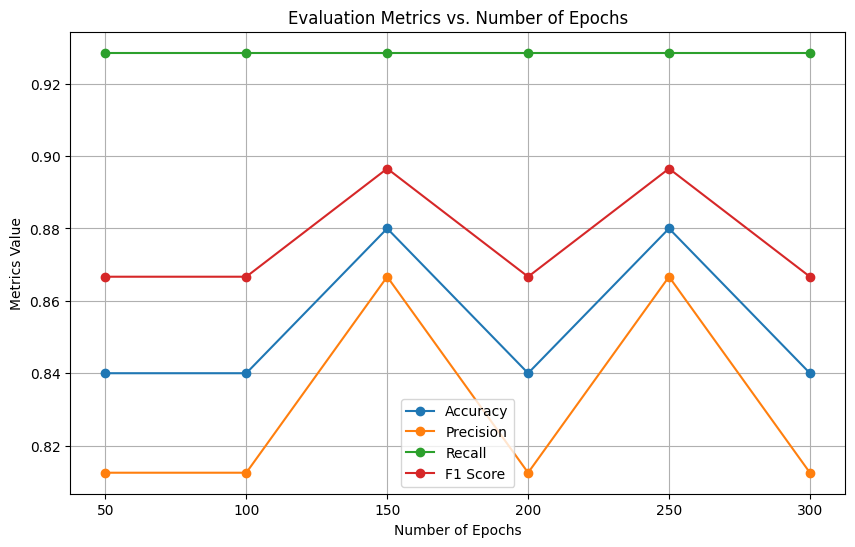

In [25]:
epochs = evaluation_df['Epochs']
accuracy = evaluation_df['Accuracy']
precision = evaluation_df['Precision']
recall = evaluation_df['Recall']
f1_score = evaluation_df['F1 Score']

# Plot
plt.figure(figsize=(10, 6))

plt.plot(epochs, accuracy, marker='o', label='Accuracy')
plt.plot(epochs, precision, marker='o', label='Precision')
plt.plot(epochs, recall, marker='o', label='Recall')
plt.plot(epochs, f1_score, marker='o', label='F1 Score')

plt.title('Evaluation Metrics vs. Number of Epochs')
plt.xlabel('Number of Epochs')
plt.ylabel('Metrics Value')
plt.legend()
plt.grid(True)
plt.xticks(epochs)
plt.show()

The same model but now with 50 epochs only.

In [26]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
import numpy as np

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers on top of the base model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)  
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

Epoch 1/50
7/7 [==============================] - 26s 2s/step - loss: 1.1692 - accuracy: 0.5644 - val_loss: 0.5823 - val_accuracy: 0.8462
Epoch 2/50
7/7 [==============================] - 8s 1s/step - loss: 0.9288 - accuracy: 0.6931 - val_loss: 0.5187 - val_accuracy: 0.8077
Epoch 3/50
7/7 [==============================] - 8s 1s/step - loss: 0.7288 - accuracy: 0.7178 - val_loss: 0.4463 - val_accuracy: 0.9231
Epoch 4/50
7/7 [==============================] - 7s 1s/step - loss: 0.6335 - accuracy: 0.7921 - val_loss: 0.4363 - val_accuracy: 0.9231
Epoch 5/50
7/7 [==============================] - 7s 1s/step - loss: 0.5872 - accuracy: 0.7921 - val_loss: 0.4219 - val_accuracy: 0.8846
Epoch 6/50
7/7 [==============================] - 8s 1s/step - loss: 0.5599 - accuracy: 0.8069 - val_loss: 0.3856 - val_accuracy: 0.8846
Epoch 7/50
7/7 [==============================] - 8s 1s/step - loss: 0.5021 - accuracy: 0.8465 - val_loss: 0.4988 - val_accuracy: 0.8077
Epoch 8/50
7/7 [========================

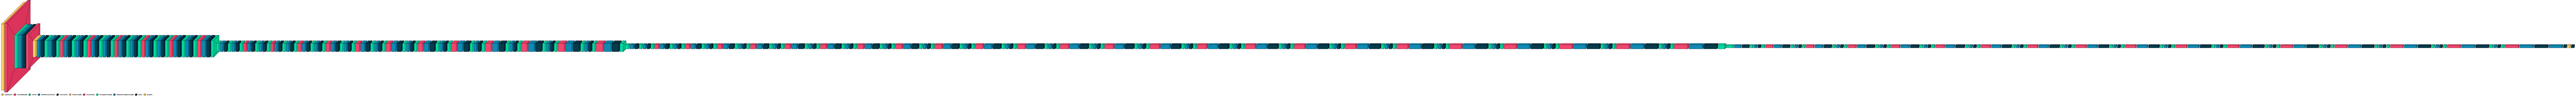

In [27]:
visualkeras.layered_view(model , legend=True)

Results of our predictions.

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predict probabilities for test data
predictions = model.predict(test_images)

# Threshold for binary predictions
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(test_labels, binary_predictions)
precision = precision_score(test_labels, binary_predictions)
recall = recall_score(test_labels, binary_predictions)
f1 = f1_score(test_labels, binary_predictions)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

1/1 [==============================] - 5s 5s/step
Accuracy: 0.84
Precision: 0.8125
Recall: 0.9285714285714286
F1 Score: 0.8666666666666666


1/1 [==============================] - 1s 909ms/step
Accuracy on Test Set: 0.840000


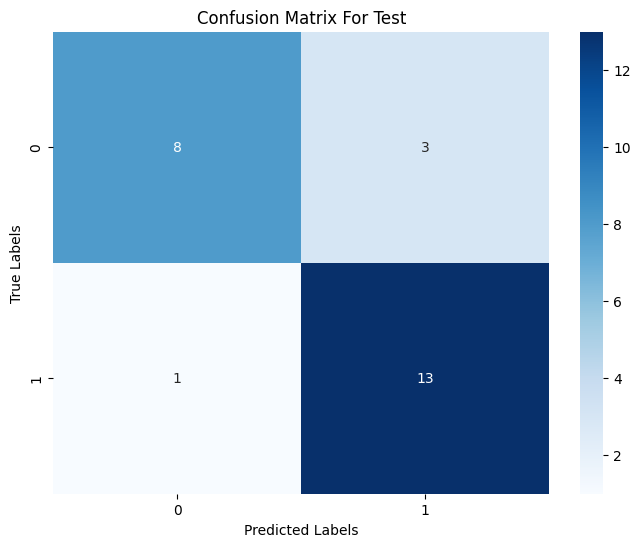

In [29]:
predictions = model.predict(test_images)
threshold = 0.5 
binary_predictions = (predictions > threshold).astype(int)

conf_matrix = confusion_matrix(test_labels, binary_predictions)

accuracy = accuracy_score(test_labels, binary_predictions)
print("Accuracy on Test Set: {:f}".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Test')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [30]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)  
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)  
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-5), metrics=['accuracy'])

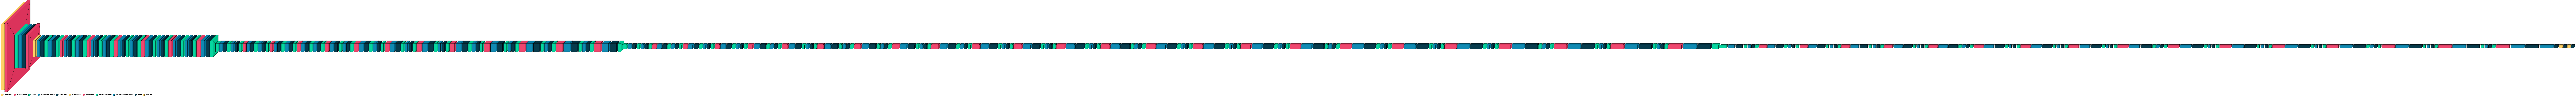

In [31]:
visualkeras.layered_view(model , legend=True)

Training the Model with 2 callbacks to improve overfitting.

In [32]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7)

history = model.fit(
    train_generator,
    epochs=200,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/200
7/7 [==============================] - 26s 2s/step - loss: 1.8744 - accuracy: 0.5149 - val_loss: 1.5869 - val_accuracy: 0.3462 - lr: 1.0000e-05
Epoch 2/200
7/7 [==============================] - 8s 1s/step - loss: 1.8030 - accuracy: 0.4703 - val_loss: 1.5277 - val_accuracy: 0.4231 - lr: 1.0000e-05
Epoch 3/200
7/7 [==============================] - 8s 1s/step - loss: 1.7548 - accuracy: 0.4802 - val_loss: 1.4800 - val_accuracy: 0.3846 - lr: 1.0000e-05
Epoch 4/200
7/7 [==============================] - 8s 1s/step - loss: 1.6811 - accuracy: 0.5099 - val_loss: 1.4384 - val_accuracy: 0.3846 - lr: 1.0000e-05
Epoch 5/200
7/7 [==============================] - 8s 1s/step - loss: 1.9213 - accuracy: 0.4455 - val_loss: 1.3994 - val_accuracy: 0.3846 - lr: 1.0000e-05
Epoch 6/200
7/7 [==============================] - 8s 1s/step - loss: 1.6934 - accuracy: 0.4950 - val_loss: 1.3665 - val_accuracy: 0.3846 - lr: 1.0000e-05
Epoch 7/200
7/7 [==============================] - 8s 1s/step - loss:

Results and Graphs of our Predictions.

1/1 [==============================] - 5s 5s/step
Accuracy on Validation Set: 0.884615


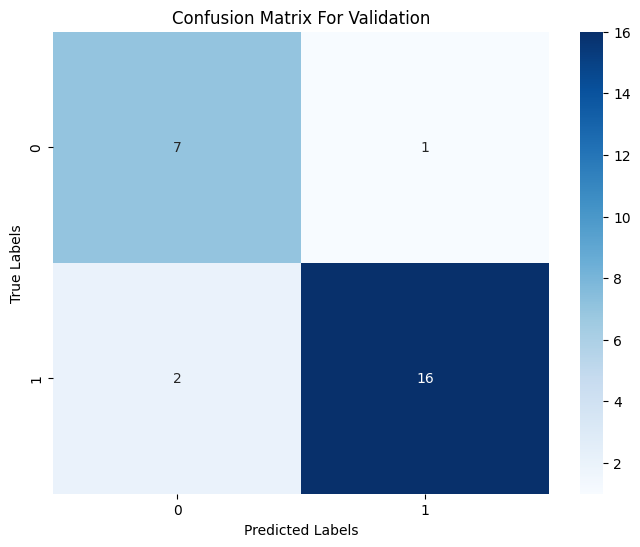

In [33]:
 predictions = model.predict(val_images)
threshold = 0.5 
binary_predictions = (predictions > threshold).astype(int)

conf_matrix = confusion_matrix(val_labels, binary_predictions)

accuracy = accuracy_score(val_labels, binary_predictions)
print("Accuracy on Validation Set: {:f}".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Validation')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

1/1 [==============================] - 2s 2s/step
Accuracy on Test Set: 0.880000


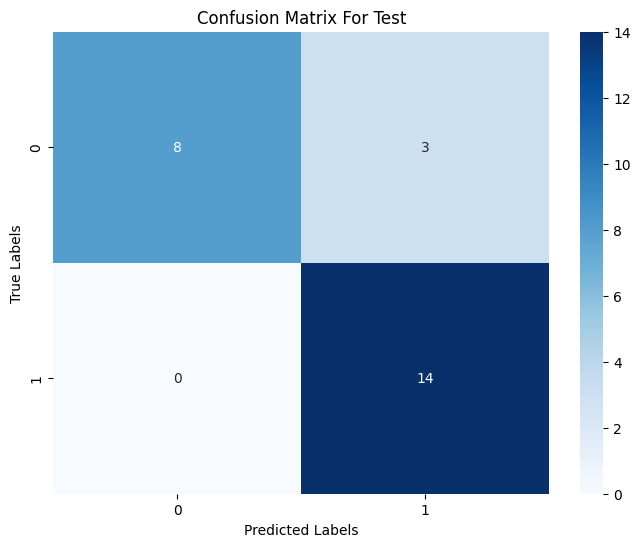

In [44]:
predictions = model.predict(test_images)
threshold = 0.55
binary_predictions = (predictions > threshold).astype(int)

conf_matrix = confusion_matrix(test_labels, binary_predictions)

accuracy = accuracy_score(test_labels, binary_predictions)
print("Accuracy on Test Set: {:f}".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Test')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

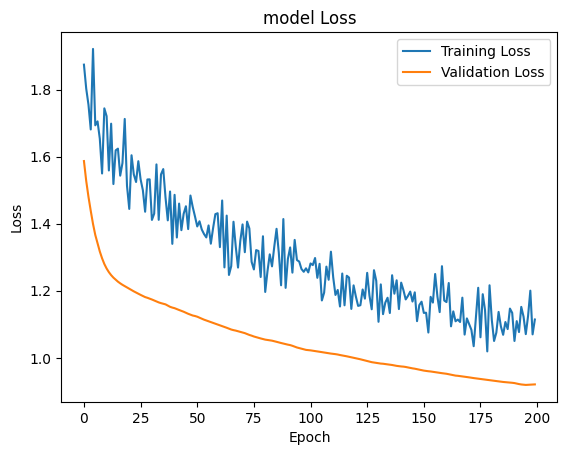

In [35]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

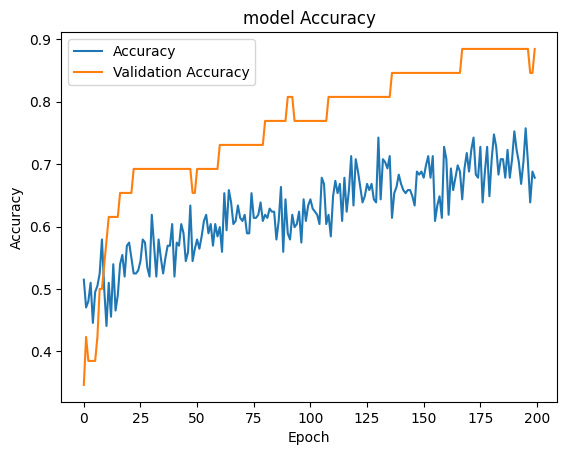

In [36]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Using a VGG16 Model With Some Modification.

In [37]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

base_model.layers[0].trainable = False


x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)  
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-5), metrics=['accuracy'])

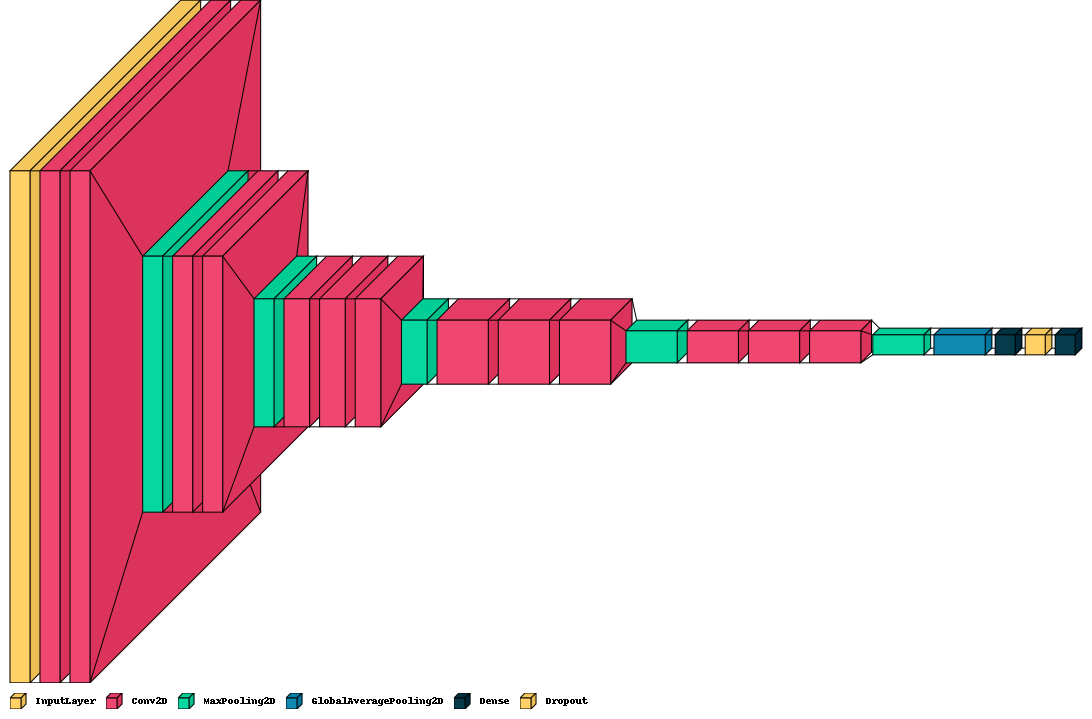

In [38]:
visualkeras.layered_view(model , legend=True)

In [39]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-7)

history = model.fit(
    train_generator,
    epochs=200,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/200
7/7 [==============================] - 59s 8s/step - loss: 0.9263 - accuracy: 0.5099 - val_loss: 0.7894 - val_accuracy: 0.6923 - lr: 1.0000e-05
Epoch 2/200
7/7 [==============================] - 49s 7s/step - loss: 0.9301 - accuracy: 0.5743 - val_loss: 0.7633 - val_accuracy: 0.6923 - lr: 1.0000e-05
Epoch 3/200
7/7 [==============================] - 48s 7s/step - loss: 0.8168 - accuracy: 0.6584 - val_loss: 0.7625 - val_accuracy: 0.7308 - lr: 1.0000e-05
Epoch 4/200
7/7 [==============================] - 48s 7s/step - loss: 0.7955 - accuracy: 0.7178 - val_loss: 0.7404 - val_accuracy: 0.7308 - lr: 1.0000e-05
Epoch 5/200
7/7 [==============================] - 48s 7s/step - loss: 0.8808 - accuracy: 0.6089 - val_loss: 0.7202 - val_accuracy: 0.6923 - lr: 1.0000e-05
Epoch 6/200
7/7 [==============================] - 48s 7s/step - loss: 0.8416 - accuracy: 0.6634 - val_loss: 0.6990 - val_accuracy: 0.8077 - lr: 1.0000e-05
Epoch 7/200
7/7 [==============================] - 48s 7s/step -

Results and Predicitons Of the VGG16 Model.

1/1 [==============================] - 2s 2s/step
Accuracy on Validation Set: 0.884615


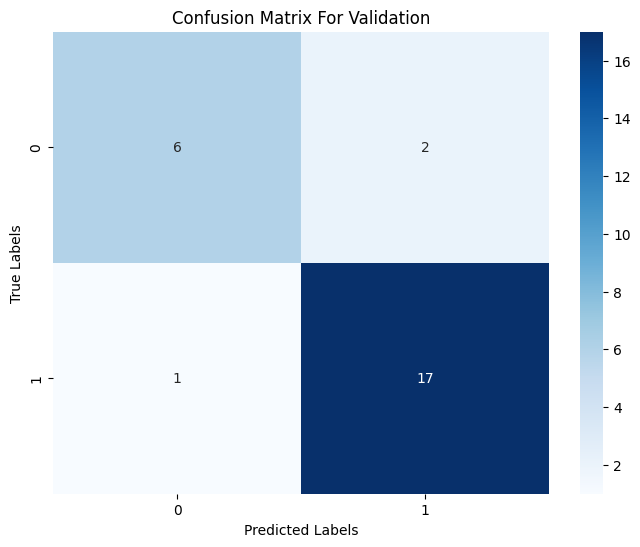

In [40]:
predictions = model.predict(val_images)
threshold = 0.5 
binary_predictions = (predictions > threshold).astype(int)

conf_matrix = confusion_matrix(val_labels, binary_predictions)

accuracy = accuracy_score(val_labels, binary_predictions)
print("Accuracy on Validation Set: {:f}".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Validation')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

1/1 [==============================] - 1s 1s/step
Accuracy on Test Set: 0.840000


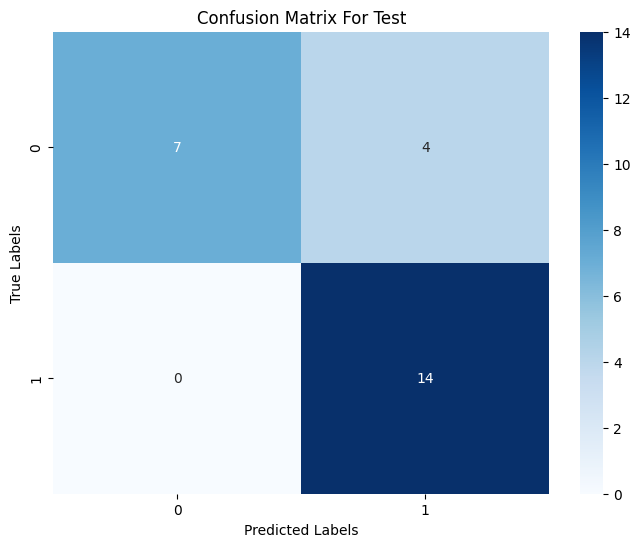

In [41]:
predictions = model.predict(test_images)
threshold = 0.5 
binary_predictions = (predictions > threshold).astype(int)

conf_matrix = confusion_matrix(test_labels, binary_predictions)

accuracy = accuracy_score(test_labels, binary_predictions)
print("Accuracy on Test Set: {:f}".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Test')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


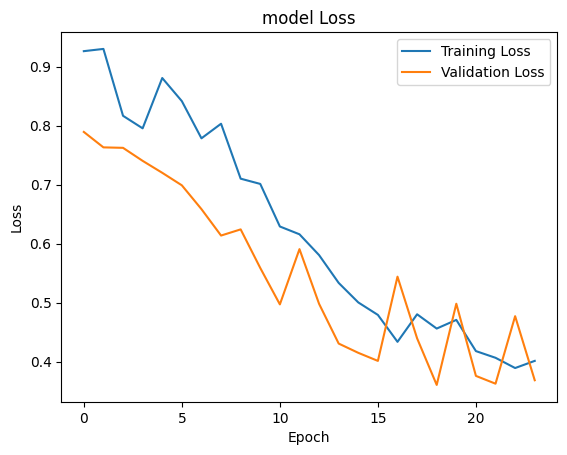

In [42]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

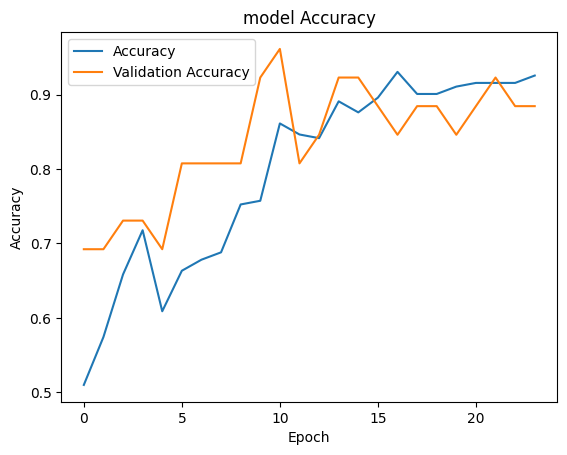

In [43]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()